# Deep Project

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torchvision

#
from torchvision.io import read_image

Download and extract dataset.

In [2]:
#!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz

zsh:1: command not found: wget


In [3]:
#!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

zsh:1: command not found: wget


In [ ]:
#!mkdir oxford-iiit-pet/
#!tar -xf images.tar.gz -C oxford-iiit-pet/
#!tar -xf annotations.tar.gz -C oxford-iiit-pet/
#!rm images.tar.gz
#!rm annotations.tar.gz


## Data preprocessing

In [1]:
from torchvision.transforms import ToTensor
from torchvision.ops.boxes import masks_to_boxes
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

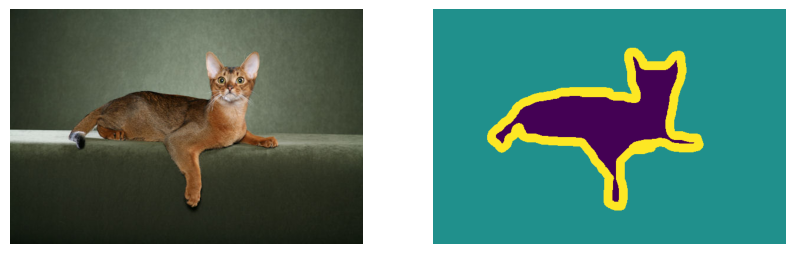

In [ ]:
# plot example image
img = read_image('oxford-iiit-pet/images/Abyssinian_1.jpg')
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.subplot(122)

mask = read_image('oxford-iiit-pet/annotations/trimaps/Abyssinian_1.png')
plt.imshow(mask.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [77]:
def transform(in_data):
    # Define a 'pipline' of functions/transformation that we want to apply to all our images (pre-processing)
    pipeline = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
    ])

    return pipeline(in_data)

def target_transform(target):
    return target


In [78]:
# Use Subset to index into dataset
from torch.utils.data import Subset

# Load in ALL the data
dataset = OxfordIIITPet(
    root='.',
    download=False,
    transform=transform,
    target_transform=target_transform,
    target_types=["category"],
)

# Range from index 0 to len(dataset)
idxes = np.arange(len(dataset))
np.random.shuffle(idxes)

# Create index lists
n = len(idxes)
train_idx = idxes[:int(n*0.8)]
test_idx = idxes[int(n*0.8):int(n*0.9)]
val_idx = idxes[int(n*0.9):]

# Split using subset class
dataset_train = Subset(dataset, train_idx)
dataset_test = Subset(dataset, test_idx)
dataset_val = Subset(dataset, val_idx)

# Create data loader
dataloader_train = DataLoader(
    dataset_train,
    batch_size=64,
    shuffle=True,
    num_workers=0,
)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=64,
    shuffle=True,
    num_workers=0,
)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=64,
    shuffle=True,
    num_workers=0,
)


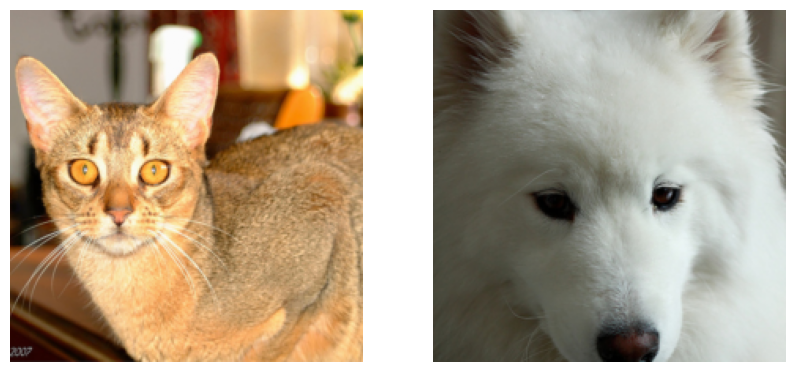

In [94]:
# Plot example images

img, target = next(iter(dataloader_train))

# plot example image
plt.figure(figsize=(10, 10))
plt.subplot(121)

plt.imshow(img[0].permute(1, 2, 0))
plt.axis('off')
plt.subplot(122)
plt.imshow(img[15].permute(1, 2, 0))
plt.axis('off')

plt.show()

print()

In [91]:
# TODO: MAYBE DO ZERO MEAN NORMALIZATION

#print(next(iter(dataloader_test))[0].shape)  # torch.Size([64, 3, 224, 224])
#img = next(iter(dataloader_test))[0][0]

#print(img.max())
#print(img.min())

#print(max(next(iter(dataloader_test))))

tensor(0.8980)
tensor(0.)


## Network setup

In [118]:
from torchvision.models import resnet18
from torchvision.models import resnet34
from torchvision.models import resnet50
#from torchvision.models import resnet101
#from torchvision.models import resnet152

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [138]:
def create_model_and_optim():

    # Load in pretrained model of our choice:
    model = resnet34(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"
    #print(model.fc.in_features)    # size of input into final layer --> 512
    #print(model.fc.out_features)   # size of output into final layer --> 1000

    # As instructed, only replace final layer with same in but one out (cat/dog)
    in_features = model.fc.in_features   # size of input into final layer

    # Create a new Linear layer to replace last fc layer with
    model.fc = torch.nn.Linear(in_features, 1)  # for binary classification instead of outputting 1000

    # Freeze all layers before final layer which we will replace
    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True   # update these layer weights (only last)


    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.0005)

    return model, optimizer


In [114]:
torch.cuda.is_available()

False

In [139]:
def train(model, optimizer, epochs=1):
  losses = []
  model.train()

  n_batch = 64

  for _ in range(epochs):
    for i, (img, binary_category) in tqdm(enumerate(dataloader_train)):
      img = img.to("cuda")
      binary_category = binary_category.to("cuda")

      output = model(img)

      loss = torch.nn.BCEWithLogitsLoss()(output, binary_category.view(-1, 1).float())
      loss.backward()   # calculate grads

      if i % n_batch == 0:
        optimizer.step()  # update weights with grads
        losses.append(loss)
        optimizer.zero_grad()  # reset grads

  return losses

In [140]:
model, optimizer = create_model_and_optim()

#model.to("cuda")
#losses = train(model, optimizer, epochs=3)

In [ ]:
import numpy as np

def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

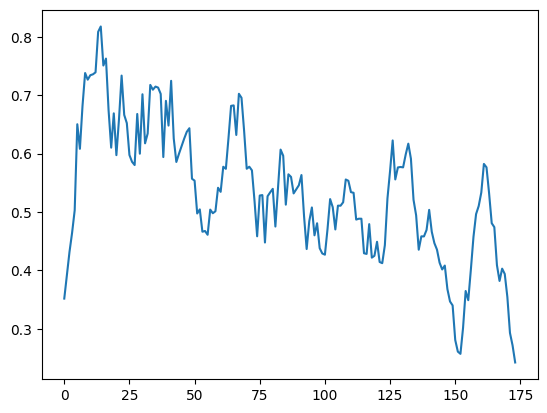

In [ ]:
losses_cpu = [loss.cpu().detach().numpy() for loss in losses]
plt.plot(smooth(losses_cpu))

In [ ]:
test_dataset = OxfordIIITPet(
    root='.',
    download=False,
    transform=transforms.Compose([
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
    ]),
    target_transform=target_transform,
    target_types=["binary-category"],
    split='test'
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

In [ ]:
img, _ = next(iter(test_dataloader))
img = img[0]
print(f'max: {torch.max(img)}')
print(f'min: {torch.min(img)}')
print(f'mean: {torch.mean(img)}')

max: 1.0
min: 0.0
mean: 0.41831111907958984


In [ ]:
total = 0
correct = 0

# no grad so it's faster
with torch.no_grad():
  model.eval()

  for i, (img, binary_category) in tqdm(enumerate(test_dataloader)):
    img = img.to("cuda")
    binary_category = binary_category.to("cuda")

    output = model(img)
    prediction = torch.round(torch.sigmoid(output))

    total += binary_category.size(0)
    correct += (prediction == binary_category).sum().item()

print(f'\nAccuracy: {100 * correct // total} %')

3669it [00:51, 71.49it/s]


Accuracy: 91 %
